In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
%cd /gdrive/My Drive/permanent/RECHERCHE3
%ls

/gdrive/My Drive/permanent/RECHERCHE3
ddqn_lib/  Euler.zip  GCN.zip    Hamilton.zip  model_2.h5     popup_lib/
Euler/     GCN/       Hamilton/  model_1.h5    model_vNet.h5  popup_lib.zip


In [7]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100000)

In [8]:
import Hamilton.autoencoder.data_maker as dat
import Hamilton.autoencoder.utilities as util
import Hamilton.autoencoder.autoencoder as models
import Hamilton.autoencoder.autoencoder_light as light
import Hamilton.autoencoder.agents as ag

In [5]:
DIM_INPUT = 16
DIM_COMPRESSION = 4
#la taille du domaine ne doit pas être excessivement grande 
domain_size=0.2

In [6]:
def test_agent(agent_kind,data_periodic=True,gradient_tape_watch_unaugmentation=False):
    
    def model_maker(input_dim,reduced_dim):
        return models.AutoEncoder(input_dim,reduced_dim)

    data_maker=dat.Data_maker_curve_periodic(DIM_INPUT,domain_size,periodic=data_periodic)
    agent=ag.Agent(model_maker,DIM_COMPRESSION, data_maker, domain_size=domain_size, kind=agent_kind,gradient_tape_watch_unaugmentation=gradient_tape_watch_unaugmentation)
    agent.train(2)
    data = data_maker.make_sorted(1000)
    prediction,final_loss = agent.predict(data)
    print("\n la loss finale est de:",final_loss)
    dat.present_data_margin(data, prediction)
    plt.show()

## Autoencodeur classique

### avec données non périodique (les doigts dans le nez)

coding layers dimensions: (without rep) [16, 13, 11, 9, 7]
⤥:7.5794⤥:4.5720⤥:2.4988⤥:1.9636⤥:1.8703⤥:1.7083⤥:1.5620⤥:1.3952⤥:1.0094⤥:0.6067⤥:0.4972⤥:0.3958.⤥:0.3208....⤥:0.3186...⤥:0.2731............................⤥:0.2713.⤥:0.2574...⤥:0.2412..............⤥:0.2300..........⤥:0.2175...⤥:0.2141............⤥:0.2098.⤥:0.1704...............⤥:0.1639.....................................................⤥:0.1639....⤥:0.1525...........................................⤥:0.1506.................⤥:0.1448.⤥:0.1371.......................⤥:0.1344...............................
 la loss finale est de: tf.Tensor(0.0013357908, shape=(), dtype=float32)


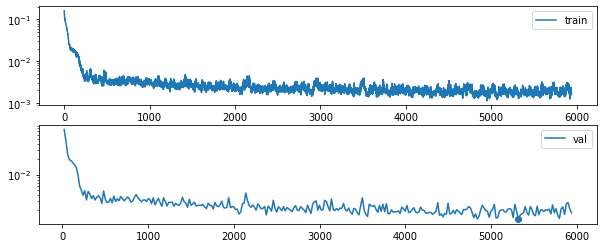

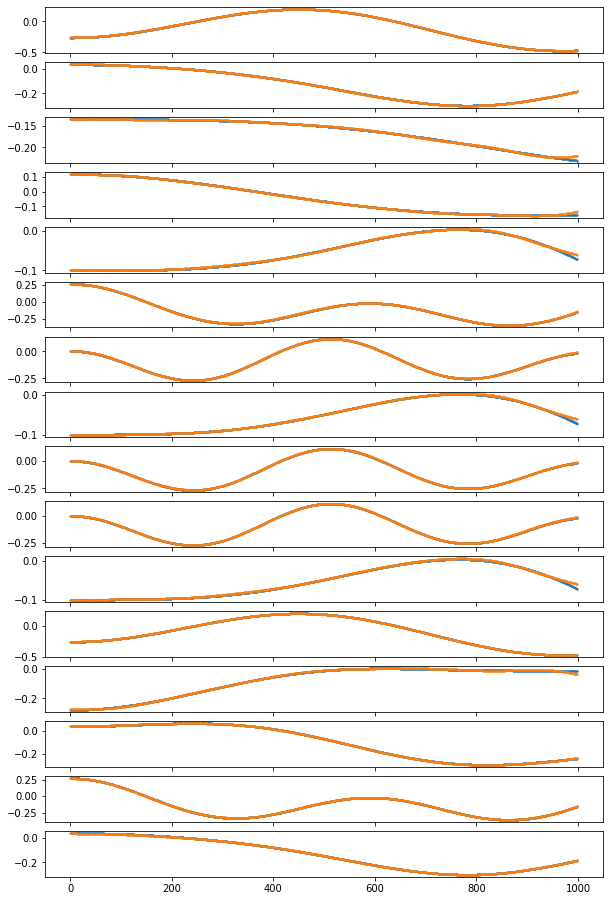

In [7]:
test_agent(ag.Agent.kind_normal,data_periodic=False)

### avec données périodiques (aille)

La courbe à apprendre est presque la même qu'avant: elle est simplement dilatée puis remise dans le domaine par périodisation. 

coding layers dimensions: (without rep) [16, 13, 11, 9, 7]
⤥:4.1232⤥:3.7006⤥:3.4419⤥:3.3411⤥:3.2990⤥:3.2782⤥:3.2450⤥:3.2423⤥:3.2357⤥:3.2297⤥:3.2252⤥:3.2192⤥:3.2147.⤥:3.2058⤥:3.1933⤥:3.1857⤥:3.1800⤥:3.1705⤥:3.1591..⤥:3.1569.⤥:3.1423⤥:3.1407...⤥:3.1368.⤥:3.1258.........⤥:3.1239....................⤥:3.1223............................................⤥:3.1184....................................................................⤥:3.1143....⤥:3.1067.⤥:3.0988⤥:3.0988⤥:3.0954.⤥:3.0901⤥:3.0814.⤥:3.0783..⤥:3.0724.⤥:3.0717..⤥:3.0692.......⤥:3.0649..⤥:3.0623..........⤥:3.0572.⤥:3.0568..⤥:3.0559⤥:3.0553⤥:3.0491⤥:3.0481..⤥:3.0409⤥:3.0354⤥:3.0231⤥:3.0201.⤥:3.0189⤥:3.0116⤥:2.9964.⤥:2.9855.⤥:2.9795...⤥:2.9755⤥:2.9668.⤥:2.9663⤥:2.9549..⤥:2.9544.⤥:2.9408.⤥:2.9356..⤥:2.9301⤥:2.9123....⤥:2.9076⤥:2.9020⤥:2.8815⤥:2.8808⤥:2.8741..⤥:2.8683.⤥:2.8652⤥:2.8448........⤥:2.8204..⤥:2.8133...⤥:2.7997..⤥:2.7959⤥:2.7844..⤥:2.7776.⤥:2.7685..⤥:2.7651...⤥:2.7610⤥:2.7585⤥:2.7575⤥:2.7471..⤥:2.7385....⤥:2.7335⤥:2.7304.⤥:2.7286.⤥

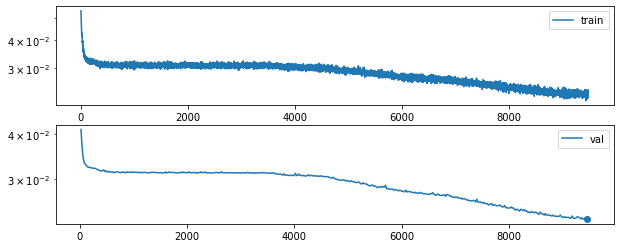

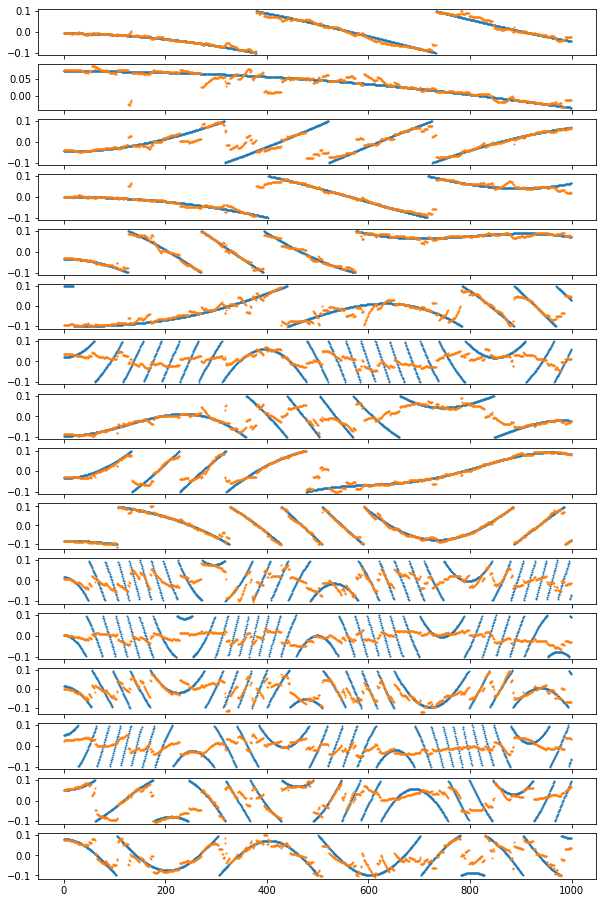

In [ ]:
test_agent(ag.Agent.kind_normal,data_periodic=True)

On essaye d'apprendre des fonctions discontinues à partir de fonctions continues. Cela fonctionne male (comme les séries de Fourier sur les fonctions discontinues).  

On remarque que l'auto-encodeur fournis souvent des valeurs "au milieu" du domaine: il essaye de passer au milieu des discontinuité. 

### en modifiant la loss  (mieux)

Maintenant, la loss est la distance "modulo la taille de domaine". Plus précisément: Quand `x_true` et  `x_pred` sont dans le domaine, la distance-modulo entre eux c'est: 

    dist_periodic(x_true,x_pred):
        diff= x_true-x_pred
        return min( |diff-domain_size|,|diff|,|diff+domain_size|)


Cela permet de traiter les 3 cas de points "proche":


    | -------------------------|
      .                      .
      x_pred               x_true   --> cas1
      .                      .
      x_true               x_pred   --> cas2

      .  .                
      x_pred                        --> cas3
         x_true




coding layers dimensions: (without rep) [16, 13, 11, 9, 7]
⤥:3.8077⤥:3.4994⤥:3.3030⤥:3.2255⤥:3.1898⤥:3.1060⤥:3.0390⤥:3.0273⤥:3.0190⤥:2.9615⤥:2.9410⤥:2.9023.⤥:2.8987⤥:2.8830.⤥:2.8758⤥:2.8615⤥:2.8593...⤥:2.8559⤥:2.8525...⤥:2.8518..⤥:2.8281⤥:2.8147⤥:2.7902⤥:2.7810⤥:2.7687⤥:2.7667⤥:2.7516⤥:2.7390.⤥:2.7271.⤥:2.7183⤥:2.7154⤥:2.7051⤥:2.7040⤥:2.6870...⤥:2.6739....⤥:2.6738....⤥:2.6688.⤥:2.6648⤥:2.6613...⤥:2.6605....⤥:2.6522⤥:2.6482⤥:2.6391⤥:2.6378.⤥:2.6145⤥:2.6071⤥:2.6025.⤥:2.5978.⤥:2.5821....⤥:2.5657......⤥:2.5622.⤥:2.5596.⤥:2.5514...⤥:2.5488.⤥:2.5333....⤥:2.5325⤥:2.5282⤥:2.5242⤥:2.5225.⤥:2.5078....⤥:2.4870.⤥:2.4818.⤥:2.4792..⤥:2.4619...⤥:2.4551⤥:2.4483.⤥:2.4308..⤥:2.4193..⤥:2.4090.⤥:2.4081⤥:2.4069⤥:2.4025⤥:2.3933⤥:2.3819.⤥:2.3711..⤥:2.3551.⤥:2.3392⤥:2.3308....⤥:2.3167⤥:2.3053.⤥:2.2958.⤥:2.2903⤥:2.2805.....⤥:2.2720⤥:2.2644..⤥:2.2494.⤥:2.2467....⤥:2.2302..⤥:2.2273..⤥:2.2149..⤥:2.2142⤥:2.2003..⤥:2.1945.⤥:2.1889⤥:2.1831⤥:2.1806⤥:2.1722.⤥:2.1598⤥:2.1541..⤥:2.1488..⤥:2.1347⤥:2.1297.⤥:2.1280.⤥:2.126

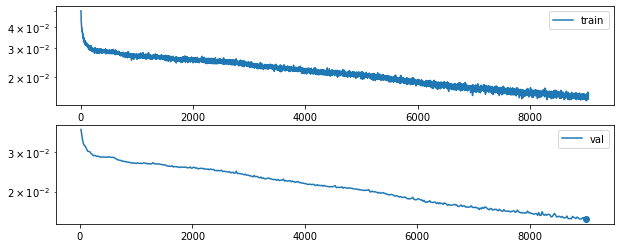

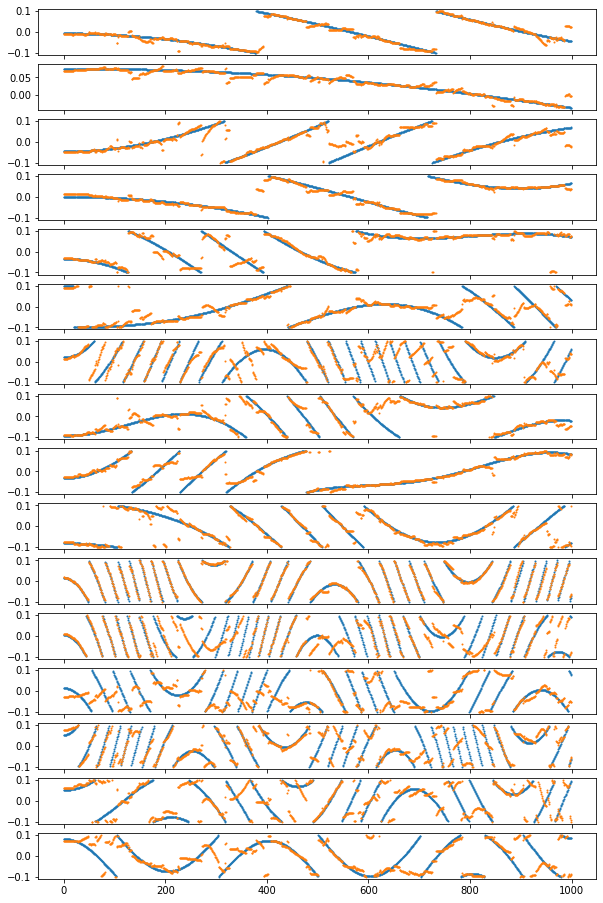

In [ ]:
test_agent(ag.Agent.kind_periodic_loss,data_periodic=True)

## Augmentation des données

### classique

Attention, la loss de validation qui apparait est relative aux donnée augmentée. 

Par contre, la loss finale est la bonne.

coding layers dimensions: (without rep) [32, 26, 21, 15, 10]
⤥:9.6615⤥:8.9339⤥:8.7205⤥:8.6299⤥:8.5962⤥:8.5825⤥:8.5679⤥:8.5543⤥:8.5309.⤥:8.5184⤥:8.5115.⤥:8.5032⤥:8.4844⤥:8.4664⤥:8.4411⤥:8.4059⤥:8.3431⤥:8.2705⤥:8.1588⤥:8.1147⤥:8.0571⤥:7.9380⤥:7.8723⤥:7.7944⤥:7.6988⤥:7.5980⤥:7.5033⤥:7.4822⤥:7.3996⤥:7.3661⤥:7.2778⤥:7.2515⤥:7.1905⤥:7.1513⤥:7.0746⤥:7.0304⤥:6.9638⤥:6.9091⤥:6.8900⤥:6.8027⤥:6.7534⤥:6.6975⤥:6.6587⤥:6.5947⤥:6.5717⤥:6.4915⤥:6.4583⤥:6.3631⤥:6.2950⤥:6.2401⤥:6.1607⤥:6.1434⤥:6.0863.⤥:5.9996..⤥:5.9357⤥:5.8881⤥:5.8373.⤥:5.8087.⤥:5.8007⤥:5.7568⤥:5.7132⤥:5.7104.⤥:5.6685.⤥:5.6490⤥:5.6227.⤥:5.6221⤥:5.5975⤥:5.5825⤥:5.5618⤥:5.5461⤥:5.5081..⤥:5.4878⤥:5.4822⤥:5.4696⤥:5.4256.⤥:5.4049.⤥:5.3688⤥:5.3618.⤥:5.3336..⤥:5.3054.⤥:5.2549⤥:5.2408.⤥:5.2107⤥:5.1861...⤥:5.1539⤥:5.1173.⤥:5.0843⤥:5.0714⤥:5.0434.⤥:5.0212⤥:4.9925⤥:4.9856⤥:4.9566⤥:4.9289..⤥:4.8858⤥:4.8761⤥:4.8562⤥:4.8469⤥:4.8048⤥:4.7912⤥:4.7756⤥:4.7661⤥:4.7435⤥:4.7171⤥:4.6950.⤥:4.6631..⤥:4.6616⤥:4.6609⤥:4.6280.⤥:4.6273⤥:4.6101⤥:4.5872⤥:4.5574.⤥:4.

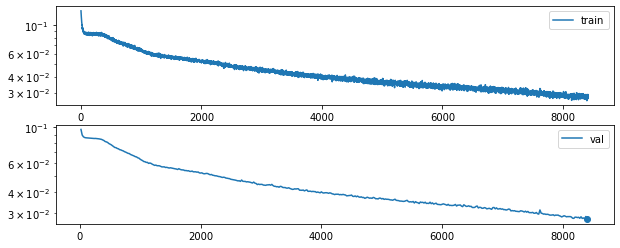

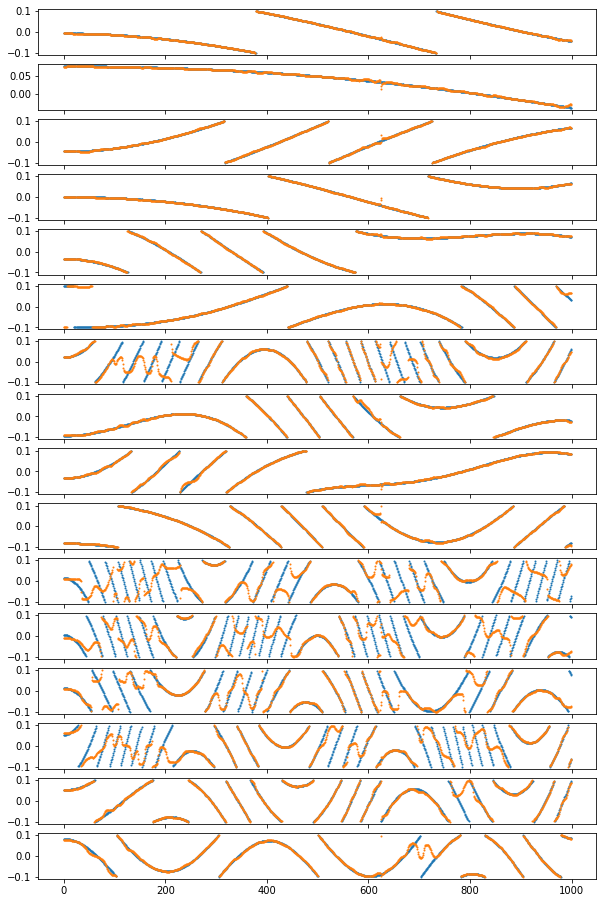

In [ ]:
test_agent(ag.Agent.kind_augmentation_circular,data_periodic=True,gradient_tape_watch_unaugmentation=False)

coding layers dimensions: (without rep) [16, 13, 11, 9, 7]
⤥:11.9115⤥:11.3580⤥:11.0360⤥:10.8288⤥:10.6851⤥:10.6094⤥:10.5355⤥:10.5027⤥:10.4604⤥:10.4271⤥:10.4096⤥:10.3758⤥:10.3473⤥:10.3112⤥:10.2458⤥:10.1787⤥:10.1258⤥:10.0756⤥:9.9973⤥:9.9459⤥:9.8596⤥:9.8060⤥:9.7096⤥:9.6399⤥:9.5861⤥:9.4937⤥:9.4424⤥:9.3874⤥:9.3119⤥:9.2934⤥:9.1934⤥:9.1230⤥:9.0603.⤥:8.9652⤥:8.9395⤥:8.8864⤥:8.8668⤥:8.7949⤥:8.7848⤥:8.7660⤥:8.7070⤥:8.6680⤥:8.6477⤥:8.6189⤥:8.5879.⤥:8.5361⤥:8.4892⤥:8.4542⤥:8.4384⤥:8.4051⤥:8.3765⤥:8.3428⤥:8.3224⤥:8.2905⤥:8.2704.⤥:8.2314.⤥:8.1888⤥:8.1549⤥:8.1455⤥:8.1203⤥:8.1094⤥:8.0619⤥:8.0451⤥:8.0318⤥:8.0230⤥:8.0121⤥:7.9676⤥:7.9207⤥:7.9203.⤥:7.9138⤥:7.8822⤥:7.8756⤥:7.8258⤥:7.8008⤥:7.7841⤥:7.7670⤥:7.7287⤥:7.7143⤥:7.6934..⤥:7.6757⤥:7.6601⤥:7.6105.⤥:7.6045⤥:7.5684⤥:7.5610⤥:7.5507⤥:7.5076.⤥:7.4938⤥:7.4823⤥:7.4766.⤥:7.4403⤥:7.4067.⤥:7.3717⤥:7.3689⤥:7.3317⤥:7.3142.⤥:7.2964.⤥:7.2923⤥:7.2888⤥:7.2450⤥:7.2271⤥:7.2173⤥:7.2056⤥:7.1669..⤥:7.1171⤥:7.0972⤥:7.0892⤥:7.0811.⤥:7.0392⤥:7.0315⤥:7.0152⤥:6.9834⤥:6.9643⤥:6

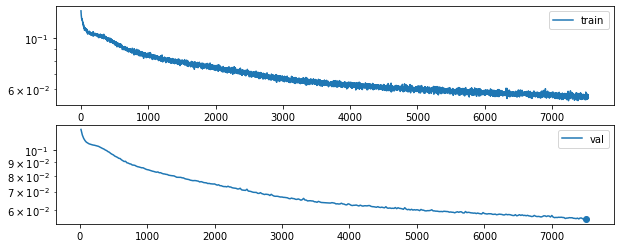

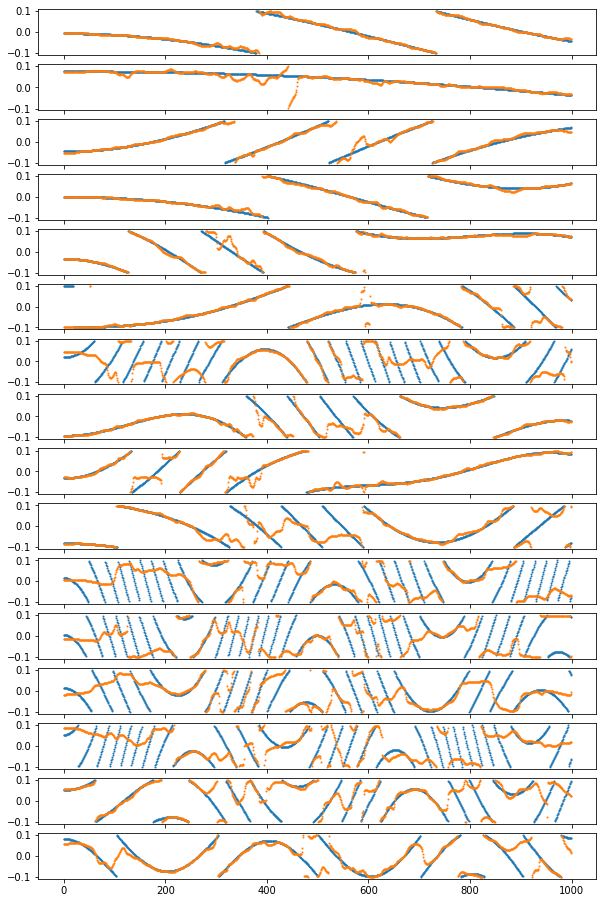

In [ ]:
test_agent(ag.Agent.kind_augmentation_circular_twice,data_periodic=True,gradient_tape_watch_unaugmentation=False)

### sous l'oeil du gradient_tape

coding layers dimensions: (without rep) [32, 26, 21, 15, 10]
⤥:3.1898⤥:2.7901⤥:2.6609⤥:2.5877⤥:2.5666⤥:2.5159.⤥:2.4857⤥:2.4534⤥:2.4507⤥:2.4344⤥:2.4075...⤥:2.3659.⤥:2.3568⤥:2.3340....⤥:2.3130.⤥:2.3027.⤥:2.2753...⤥:2.2605...⤥:2.2231.....⤥:2.2209⤥:2.1876.⤥:2.1717.⤥:2.1499⤥:2.1428⤥:2.1310⤥:2.1011.....⤥:2.0951⤥:2.0921⤥:2.0765⤥:2.0563⤥:2.0402⤥:1.9968⤥:1.9721⤥:1.9584⤥:1.9435⤥:1.9253⤥:1.9117.⤥:1.8867.⤥:1.8797⤥:1.8759⤥:1.8406⤥:1.8260⤥:1.8043⤥:1.7861.⤥:1.7608⤥:1.7289⤥:1.7269⤥:1.6878⤥:1.6840⤥:1.6509.⤥:1.6248.⤥:1.5954⤥:1.5667.⤥:1.5461⤥:1.5388.⤥:1.5323.⤥:1.5107⤥:1.4699.⤥:1.4337.⤥:1.4303..⤥:1.4093⤥:1.3825.⤥:1.3479⤥:1.3346⤥:1.3126⤥:1.2882⤥:1.2768⤥:1.2642⤥:1.2564⤥:1.2433..⤥:1.2426..⤥:1.1775⤥:1.1681⤥:1.1601⤥:1.1573..⤥:1.1487⤥:1.1409⤥:1.1191⤥:1.0820⤥:1.0673....⤥:1.0432⤥:1.0392⤥:1.0043.⤥:0.9999..⤥:0.9968⤥:0.9861.⤥:0.9631...⤥:0.9247...⤥:0.8979⤥:0.8654..⤥:0.8575..⤥:0.8370....⤥:0.8194.⤥:0.8125⤥:0.8043.⤥:0.7953.....⤥:0.7691⤥:0.7634⤥:0.7494......⤥:0.7457⤥:0.7161.......⤥:0.6979.⤥:0.6927.⤥:0.6925⤥:0.6771.⤥:0.67

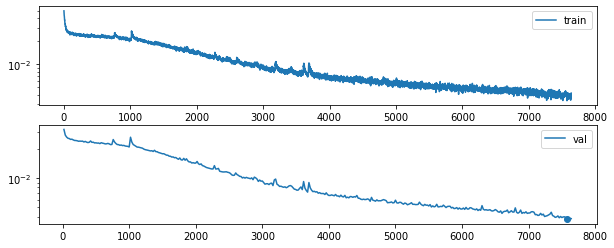

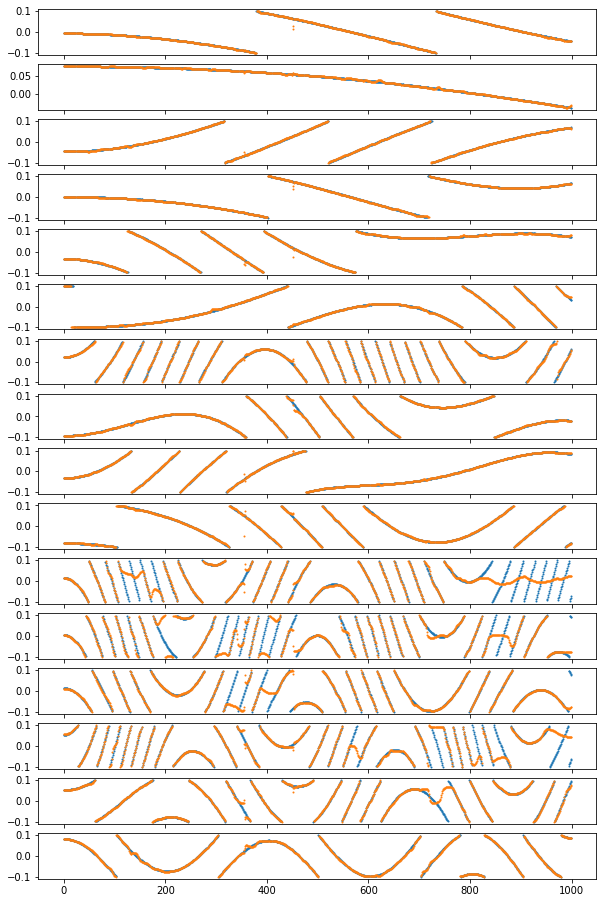

In [ ]:
test_agent(ag.Agent.kind_augmentation_circular,data_periodic=True,gradient_tape_watch_unaugmentation=True)

### Essai bof

Ici un essaie en utilisant le même raiseau de neurone pour la partie cosinus et la partie sinus. Pas très concluant. 

J'arrivais à une loss de 0.015829436

J'ai supprimer cette possibilité de mon agent.


## Grande dimension

### Il faut changer



Pour travailler avec 

    DIM_INPUT = 10_000
    DIM_COMPRESSION = 30

On imagine une décroissance du genre

    10_000,5_000,3_000,1000,500,100,30

Ce qui donne en nombre de paramètres:

In [7]:
np.prod([10_000,5_000,3_000,1000,500,100,30])

3639071115485380608

Aille ça fait mal

### Light autoencodeur: principe

dessinons l'encodeur seulement

successive_feat_dim of encoder only: [16, '(4, 2)->', 8, '(4, 2)->', 4, 2]


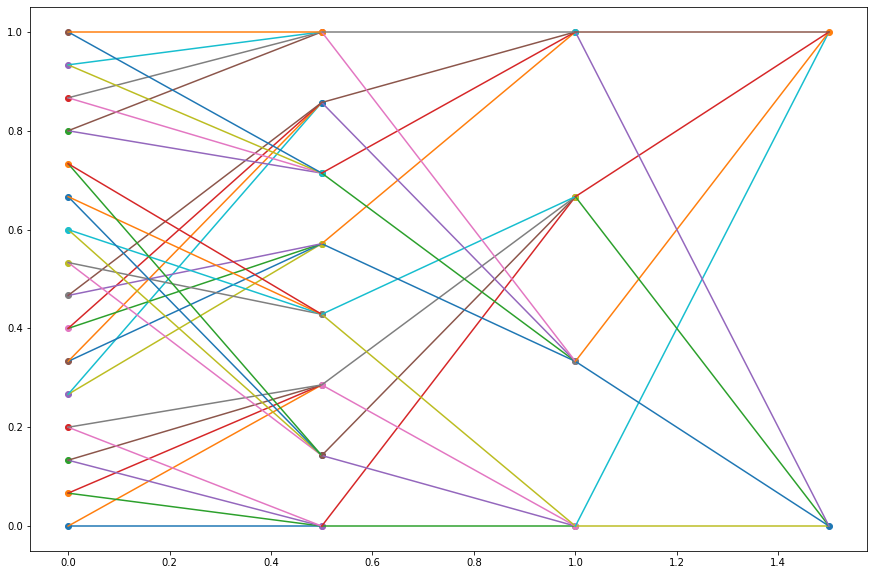

In [9]:
light.LAE_simulator(16, [(4, 2),(4,2)],2,only_enc=True,draw=True)

Sans mixer:

successive_feat_dim of encoder only: [16, '(4, 2)->', 8, '(4, 2)->', 4, 2]


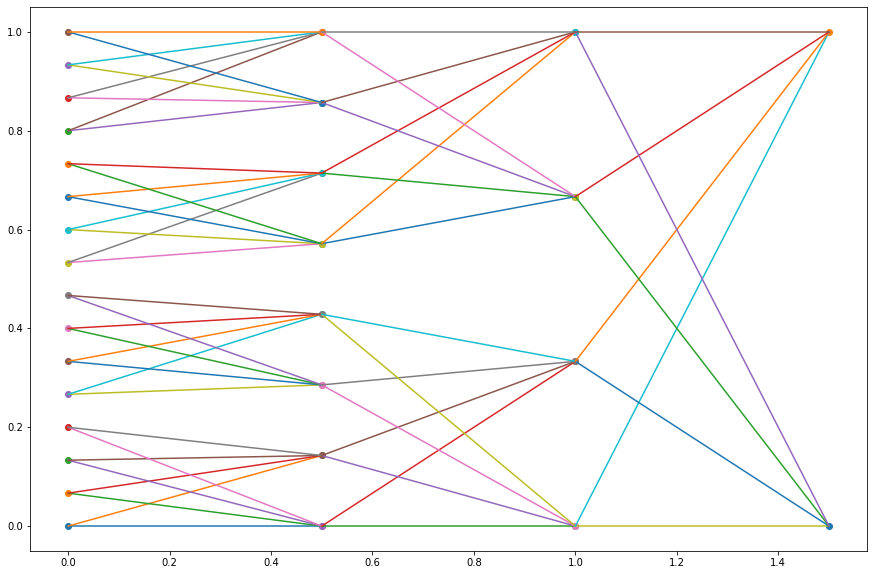

In [10]:
light.LAE_simulator(16, [(4, 2),(4,2)],2,only_enc=True,draw=True,mix=False)

successive_feat_dim of the compo: [16, '(4, 2)->', 8, '(4, 2)->', 4, 2, 4, '(2, 4)->', 8, '(2, 4)->', 16]
ratio total_param/total_param_if_full: 0.32558139534883723


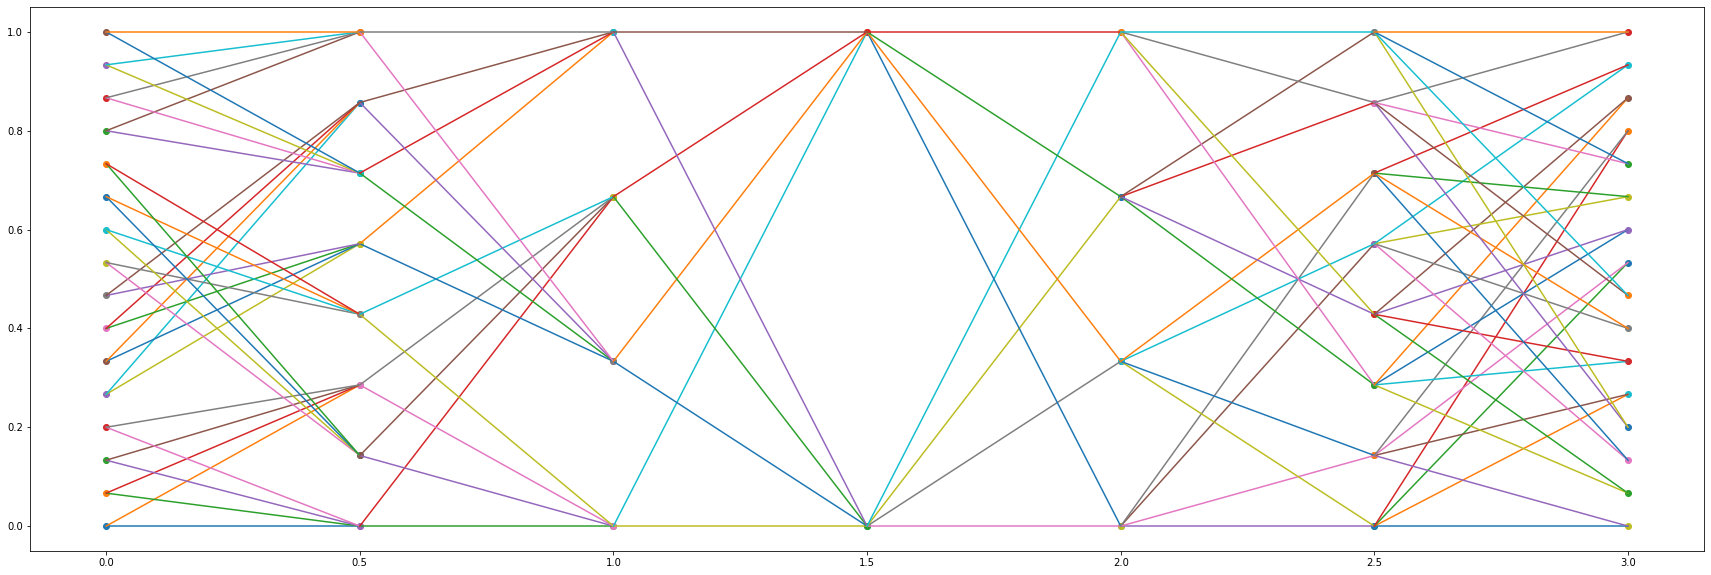

In [11]:
light.LAE_simulator(16, [(4, 2),(4,2)],2,only_enc=False,draw=True)

On n'est pas obligé de diviser par 2 le nombre de neurones:

successive_feat_dim of encoder only: [27, '(3, 2)->', 18, '(3, 2)->', 12, 2]


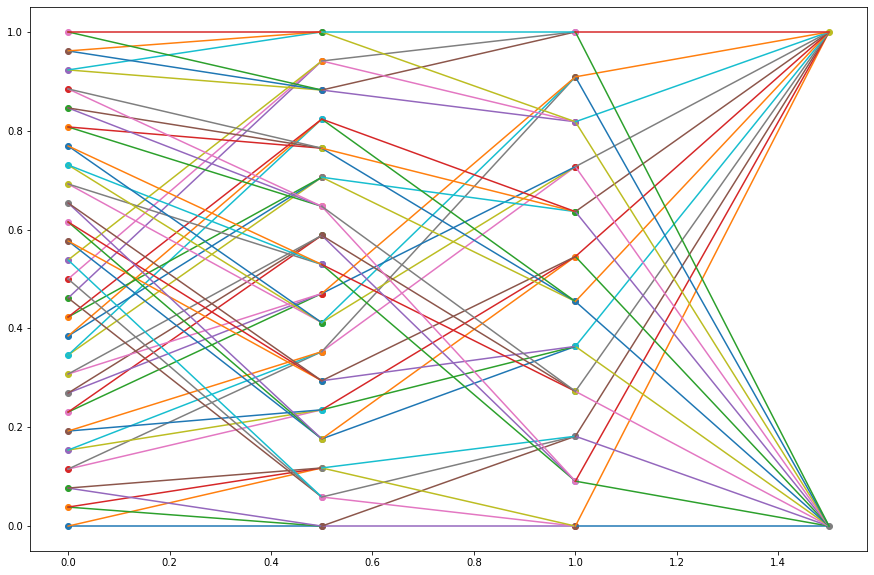

In [12]:
light.LAE_simulator(27, [(3, 2),(3, 2)],2,only_enc=True,draw=True)

On peut faire de gros paquet pour avoir quand même beaucoup de paramètres

successive_feat_dim of encoder only: [100, '(10, 5)->', 50, '(10, 5)->', 25, 2]


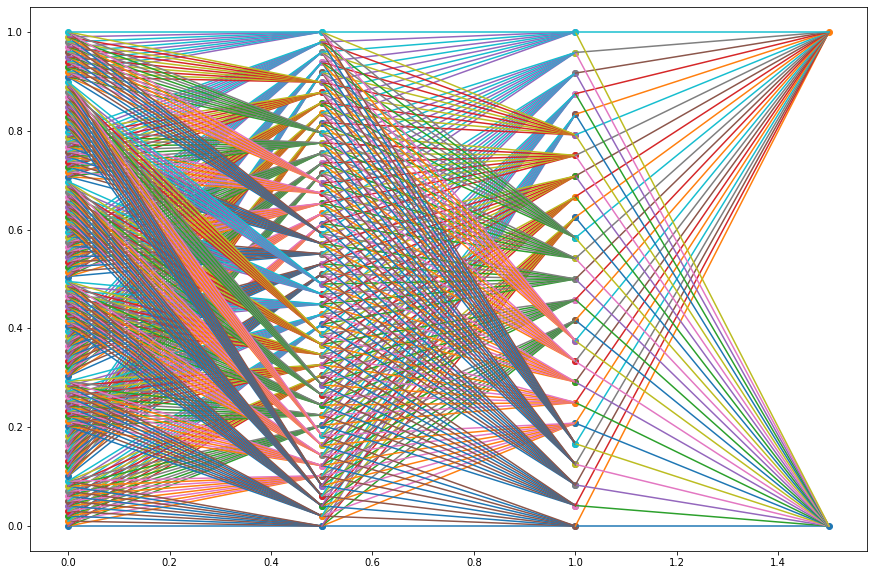

In [13]:
model=light.LAE_simulator(100, [(10,5),(10,5)],2,only_enc=True,draw=True)

### Condition sur la structure: 

Le nombre de feature à chaque couche doit être divisible par le premier nombre du couple. 

Par symétrie: si l'encodeur est OK, alors le décodeur est OK. 

Le simulateur peut aider à trouver la bonne structure:

In [18]:
struc_enc=[(10,5),(10,5)]
light.LAE_simulator(1000, struc_enc,30,only_enc=True,draw=False);

successive_feat_dim of encoder only: [1000, '(10, 5)->', 500, '(10, 5)->', 250, 30]


In [19]:
struc_enc=[(10,5),(10,5),(10,5)]
light.LAE_simulator(1000, struc_enc,30,only_enc=True,draw=False);

successive_feat_dim of encoder only: [1000, '(10, 5)->', 500, '(10, 5)->', 250, '(10, 5)->', 125, 30]


In [20]:
struc_enc=[(10,5),(10,5),(10,5),(5,3)]
light.LAE_simulator(1000, struc_enc,30,only_enc=True,draw=False);

successive_feat_dim of encoder only: [1000, '(10, 5)->', 500, '(10, 5)->', 250, '(10, 5)->', 125, '(5, 3)->', 75, 30]


In [21]:
struc_enc=[(10,5),(10,5),(10,5),(5,3),(5,3)]
light.LAE_simulator(1000, struc_enc,30,only_enc=True,draw=False);

successive_feat_dim of encoder only: [1000, '(10, 5)->', 500, '(10, 5)->', 250, '(10, 5)->', 125, '(5, 3)->', 75, '(5, 3)->', 45, 30]


## Le vrai test

In [16]:
DIM_INPUT = 20_000
DIM_COMPRESSION = 30

In [23]:
STRUC_ENC=[(500,200),(500,200),(320,100),(100,50),(50,20),(50,20),(40,20)]
light.LAE_simulator(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION)

successive_feat_dim of the compo: [20000, '(500, 200)->', 8000, '(500, 200)->', 3200, '(320, 100)->', 1000, '(100, 50)->', 500, '(50, 20)->', 200, '(50, 20)->', 80, '(40, 20)->', 40, 30, 40, '(20, 40)->', 80, '(20, 50)->', 200, '(20, 50)->', 500, '(50, 100)->', 1000, '(100, 320)->', 3200, '(200, 500)->', 8000, '(200, 500)->', 20000]
ratio total_param/total_param_if_full: 0.03160585490701645


In [24]:
model=light.LAE(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION,mix=False)
model.compo.summary()

successive_feat_dim: [20000, 8000, 3200, 1000, 500, 200, 80, 40, 30, 40, 80, 200, 500, 1000, 3200, 8000, 20000]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
model (Functional)           (None, 30)                241640    
_________________________________________________________________
model_1 (Functional)         (None, 20000)             242600    
Total params: 484,240
Trainable params: 484,240
Non-trainable params: 0
_________________________________________________________________


### Entrainement

In [25]:
def test_agent_light(input_dim,struc_enc,reduced_dim):
    data_maker=dat.Data_maker_curve_periodic(DIM_INPUT,1.,periodic=False)
    def model_maker_light(input_dim,reduced_dim):
        return light.LAE(input_dim,struc_enc,reduced_dim,mix=False)
    
    agent=ag.Agent(model_maker_light,DIM_COMPRESSION, data_maker, domain_size=1., kind=ag.Agent.kind_normal,batch_size=64)
    agent.train(0.5)

    data = data_maker.make_sorted(1000)
    prediction,final_loss = agent.predict(data)
    print("\n la loss finale est de:",final_loss)
    dat.present_data_margin(data, prediction)
    plt.show()

successive_feat_dim: [20000, 8000, 3200, 1000, 500, 200, 80, 40, 30, 40, 80, 200, 500, 1000, 3200, 8000, 20000]
⤥:56.5063⤥:55.0719⤥:53.0987⤥:49.3131⤥:44.3698⤥:39.5040⤥:35.9112⤥:33.4057⤥:31.5500⤥:30.0003⤥:28.6793⤥:27.6078⤥:26.5430⤥:25.7511⤥:24.9089⤥:24.3291⤥:23.6150⤥:23.0861⤥:22.6435⤥:22.2637⤥:21.8587⤥:21.5320⤥:21.1450⤥:20.8171⤥:20.5820⤥:20.4347⤥:20.1688⤥:20.0387⤥:19.7319⤥:19.6533⤥:19.6354⤥:19.3572⤥:19.2221⤥:19.1124⤥:18.9145⤥:18.8941⤥:18.6843⤥:18.6007⤥:18.5163⤥:18.4748.⤥:18.3652⤥:18.1683⤥:18.1013.⤥:18.0972⤥:18.0683⤥:17.8602.⤥:17.7625⤥:17.7159⤥:17.6026.⤥:17.5452⤥:17.5224⤥:17.4562.⤥:17.3695⤥:17.3630..⤥:17.3407⤥:17.2284⤥:17.1390⤥:17.0810.⤥:17.0529⤥:17.0264⤥:16.9687....⤥:16.9462⤥:16.9239⤥:16.8462⤥:16.8251.⤥:16.8008⤥:16.7510⤥:16.7079⤥:16.6683.⤥:16.6634⤥:16.6425⤥:16.6366⤥:16.6048..⤥:16.5517⤥:16.5419...⤥:16.4834⤥:16.4772.⤥:16.4379⤥:16.4202⤥:16.4098..⤥:16.3960⤥:16.3456⤥:16.3135....⤥:16.2571..⤥:16.2517⤥:16.2363⤥:16.2254.⤥:16.1992⤥:16.1855...⤥:16.1845.⤥:16.1163..⤥:16.0853.....⤥:16.0639⤥:16.0210..

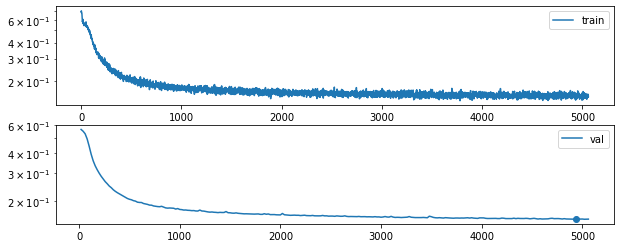

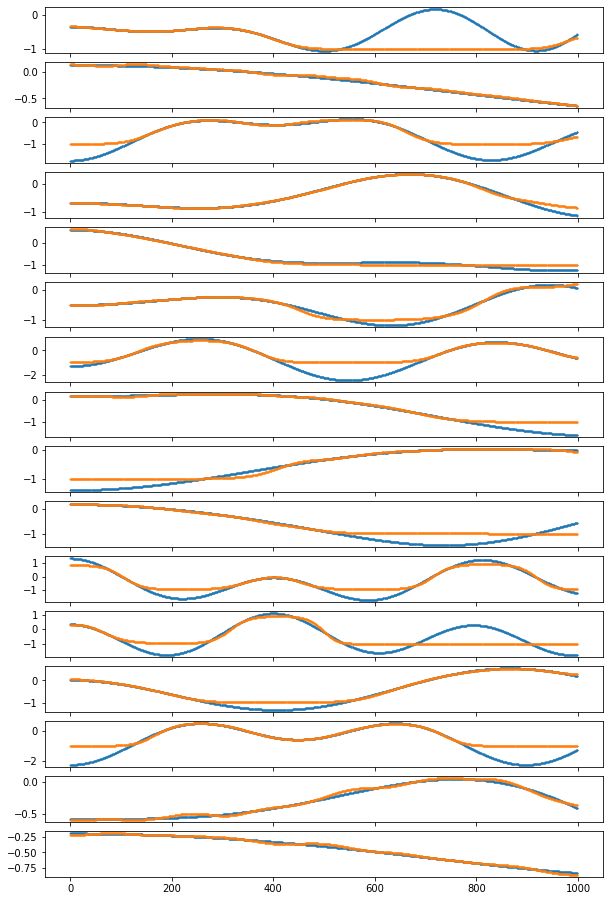

In [26]:
test_agent_light(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION)

### Plus facile

In [36]:
DIM_INPUT = 6_000
DIM_COMPRESSION = 30

In [37]:
STRUC_ENC=[(300,100),(200,100),(100,50),(250,100),(100,60)]
light.LAE_simulator(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION)

successive_feat_dim of the compo: [6000, '(300, 100)->', 2000, '(200, 100)->', 1000, '(100, 50)->', 500, '(250, 100)->', 200, '(100, 60)->', 120, 30, 120, '(60, 100)->', 200, '(100, 250)->', 500, '(50, 100)->', 1000, '(100, 200)->', 2000, '(100, 300)->', 6000]
ratio total_param/total_param_if_full: 0.06257090138727534


In [38]:
model=light.LAE(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION,mix=False)
model.compo.summary()

successive_feat_dim: [6000, 2000, 1000, 500, 200, 120, 30, 120, 200, 500, 1000, 2000, 6000]
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 6000)]            0         
_________________________________________________________________
model_27 (Functional)        (None, 30)                90040     
_________________________________________________________________
model_28 (Functional)        (None, 6000)              90670     
Total params: 180,710
Trainable params: 180,710
Non-trainable params: 0
_________________________________________________________________


successive_feat_dim: [6000, 2000, 1000, 500, 200, 120, 30, 120, 200, 500, 1000, 2000, 6000]
⤥:56.3494⤥:54.1514⤥:50.8088⤥:46.8359⤥:43.0503⤥:39.7848⤥:37.1310⤥:35.0714⤥:33.4310⤥:31.9449⤥:30.6978⤥:29.6297⤥:28.6308⤥:27.8001⤥:26.9567⤥:26.2433⤥:25.5621⤥:24.9549⤥:24.4315⤥:23.9263⤥:23.5219⤥:23.0103⤥:22.6382⤥:22.4064⤥:21.9393⤥:21.6258⤥:21.4387⤥:21.1114⤥:21.0078⤥:20.6720⤥:20.4853⤥:20.2378⤥:20.0673⤥:19.9024⤥:19.7347⤥:19.6325⤥:19.4908⤥:19.3349⤥:19.1751⤥:19.0335.⤥:18.9054⤥:18.7346⤥:18.6684⤥:18.6663⤥:18.4768⤥:18.3962⤥:18.2940⤥:18.1657⤥:18.1208⤥:18.0202⤥:17.9989⤥:17.9610⤥:17.9262⤥:17.8962⤥:17.8043⤥:17.7118.⤥:17.6366⤥:17.6032⤥:17.5790⤥:17.5490⤥:17.4932⤥:17.4203⤥:17.3811..⤥:17.2678⤥:17.2421⤥:17.1831⤥:17.1293.⤥:17.1174⤥:17.0610⤥:16.9973⤥:16.9667.⤥:16.9474⤥:16.8967⤥:16.8248⤥:16.8214⤥:16.7837⤥:16.7797⤥:16.7724⤥:16.7400..⤥:16.6956⤥:16.6662⤥:16.6576⤥:16.6507⤥:16.6375⤥:16.5850..⤥:16.5322⤥:16.4997⤥:16.4868⤥:16.4469.⤥:16.4438.⤥:16.4108⤥:16.3769⤥:16.3557.⤥:16.3469⤥:16.3362.⤥:16.2852....⤥:16.2734⤥:16.2382⤥:16.219

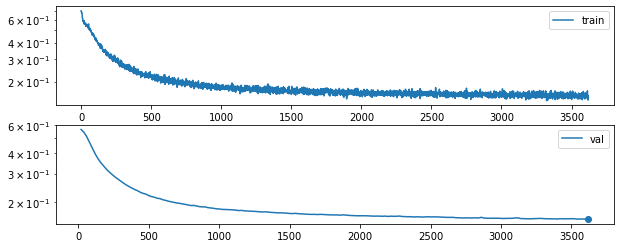

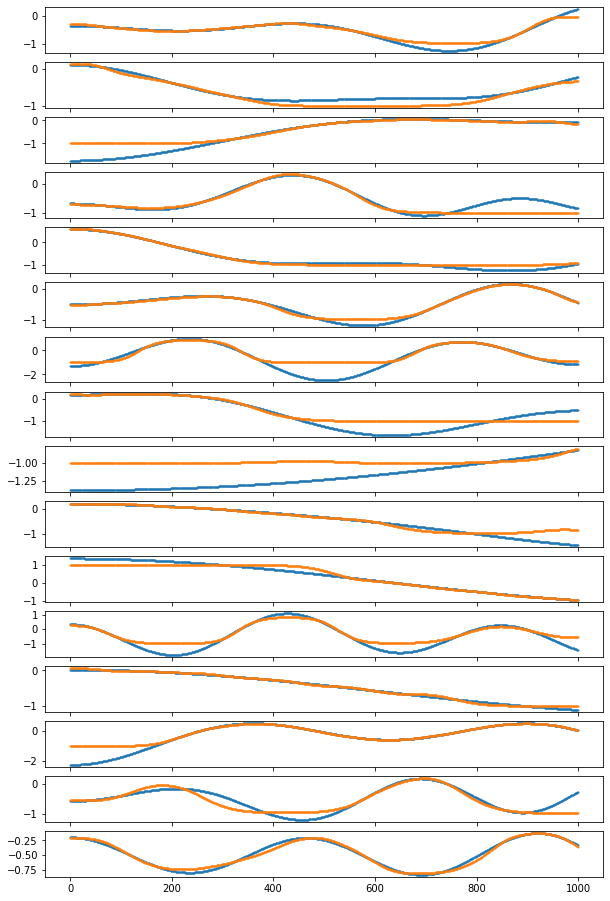

In [39]:
test_agent_light(DIM_INPUT,STRUC_ENC,DIM_COMPRESSION)